In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image


from tyssue import config, Sheet, SheetGeometry, History, EventManager
from tyssue.draw import sheet_view
from tyssue.generation import three_faces_sheet
from tyssue.draw.plt_draw import plot_forces

from tyssue.dynamics import PlanarModel

from tyssue.solvers.viscous import EulerSolver
from tyssue.draw.plt_draw import create_gif


geom  = SheetGeometry
model = PlanarModel

This notebooks demonstrates usage of the time dependant solver `EulerSolver` in the simplest case where we solve
$$\eta_i \frac{d\mathbf{r}_i}{dt}  = \mathbf{F}_i = - \mathbf{\nabla}_i E$$

The model is defined in the same way it is defined for the quasistatic solver.

###  Simple forward Euler solver

$$\mathbf{r}_i(t+dt) = \mathbf{r}_i(t) + \frac{\mathbf{F}_i(t)}{\eta} dt$$


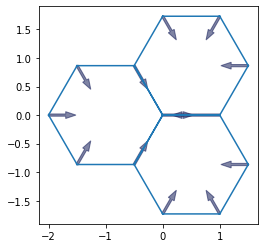

In [3]:
sheet = Sheet('3', *three_faces_sheet())
geom.update_all(sheet)
sheet.settings['threshold_length'] = 1e-3

sheet.update_specs(config.dynamics.quasistatic_plane_spec())
sheet.face_df["prefered_area"] = sheet.face_df["area"].mean()
history = History(sheet, extra_cols={"edge":["dx", "dy"]})

sheet.vert_df['viscosity'] = 1.0
sheet.edge_df.loc[[0, 17],  'line_tension'] *= 4

fig, ax = plot_forces(sheet, geom, model, ['x', 'y'], 1)

Solver instanciation

In [4]:
solver = EulerSolver(
    sheet,
    geom,
    model,
    history=history,
    auto_reconnect=True)


The solver's `solve` method accepts a `on_topo_change` function as argument. This function is executed each time a topology change occurs. Here, we reste the line tension to its original value.

In [5]:
def on_topo_change(sheet):
    print("reseting tension")
    sheet.edge_df["line_tension"] = sheet.specs["edge"]["line_tension"]


### Solving from $t = 0$ to $t = 8$

In [6]:
res = solver.solve(tf=8, dt=0.05, on_topo_change=on_topo_change,
                   topo_change_args=(solver.eptm,))

reseting tension
reseting tension


### Showing the results

In [7]:
create_gif(solver.history, "sheet3.gif")

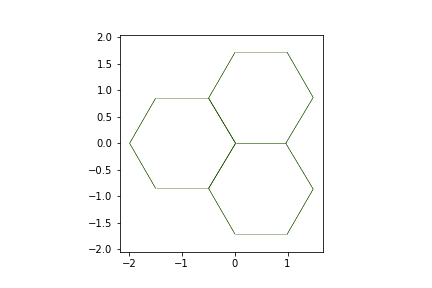

In [8]:
Image("sheet3.gif")


In [9]:
with pd.HDFStore("simple_history.hf5", 'a') as store:
    for key, df in history.datasets.items():
        store.append(key=key, value=df, data_columns=['time'])

In [10]:
from tyssue import HistoryHdf5

In [11]:
retrieved = HistoryHdf5.from_archive("simple_history.hf5")

from_archive


In [13]:

sheet_0 = retrieved.retrieve(0)